## <CENTER>Classifying Twitter Tweets as Trolls based on the Toxicity/ Hate Words in the Tweet using Natural Language Processing (NLP)</CENTER>

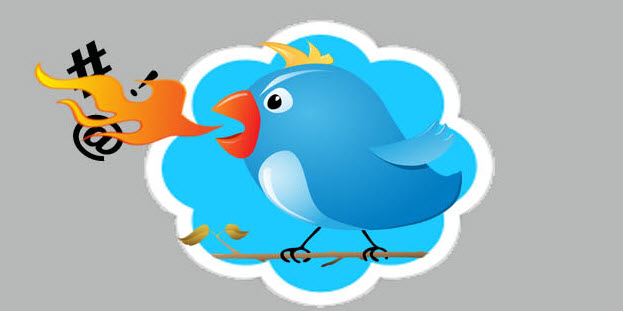

In [1]:
#importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import nltk
import string
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
sns.set_style('whitegrid')

pd.set_option("display.max_colwidth", 200) 
%matplotlib inline

In [2]:
# loading the dataset of twitter tweets where the training data is labelled a 0 if a comment is not a troll \
# and 1 if a comment is a troll
train = pd.read_csv('train_tweets.csv')
test = pd.read_csv('test_tweets.csv')

### Exploratory Data Analysis

In [3]:

train.shape

(31962, 3)

In [4]:
test.shape

(17197, 2)

In [5]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


<Axes: >

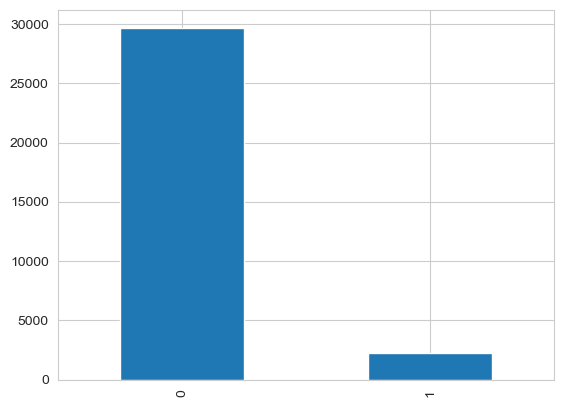

In [6]:
train['label'].value_counts().plot(kind= 'bar')
#highly imbalanced classes

In [7]:
train[train['label']==1] #troll/ hate comments

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
...,...,...,...
31934,31935,1,lady banned from kentucky mall. @user #jcpenny #kentucky
31946,31947,1,@user omfg i'm offended! i'm a mailbox and i'm proud! #mailboxpride #liberalisme
31947,31948,1,@user @user you don't have the balls to hashtag me as a but you say i am to weasel away.. lumpy tony.. dipshit.
31948,31949,1,"makes you ask yourself, who am i? then am i anybody? until ....god . oh thank you god!"


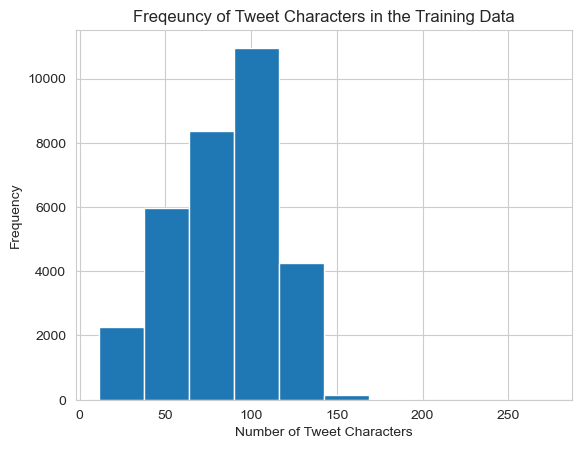

In [8]:
train['tweet'].str.len().hist() #length of number of words in training set
plt.xlabel('Number of Tweet Characters')
plt.ylabel('Frequency')
plt.title('Freqeuncy of Tweet Characters in the Training Data')
plt.show()

### Preprocessing the data

In [9]:

# combining the training and test data which will be split later 
combined_df = train.append(test,ignore_index=True,sort=False)

/var/folders/p_/d57tpnkj54l60xy2z6dzdd400000gn/T/ipykernel_33995/138581870.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = train.append(test,ignore_index=True,sort=False)


In [10]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mishika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [12]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
#removing all unnecessary special characters and retaining only required words 
clean_tweets = []
for i in range(0, len(combined_df)):
    clean = re.sub('[^a-zA-Z#]', ' ', combined_df['tweet'][i])#using regex function to remove all special characters
    clean = clean.lower()
    clean = clean.split()
    ps = PorterStemmer() #intializing the function to keep root of the words
    all_stopwords = stopwords.words('english')
    review = [ps.stem(word) for word in clean if not word in set(all_stopwords)]
    clean= ' '.join(clean)
    clean_tweets.append(clean)

In [14]:
clean_tweets

['user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run',
 'user user thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked',
 'bihday your majesty',
 '#model i love u take with u all the time in ur',
 'factsguide society now #motivation',
 'huge fan fare and big talking before they leave chaos and pay disputes when they get there #allshowandnogo',
 'user camping tomorrow user user user user user user user danny',
 'the next school year is the year for exams can t think about that #school #exams #hate #imagine #actorslife #revolutionschool #girl',
 'we won love the land #allin #cavs #champions #cleveland #clevelandcavaliers',
 'user user welcome here i m it s so #gr',
 '#ireland consumer price index mom climbed from previous to in may #blog #silver #gold #forex',
 'we are so selfish #orlando #standwithorlando #pulseshooting #orlandoshooting #biggerproblems #selfish #heabreaking #values #lov

In [15]:
combined_df['clean_tweets'] = clean_tweets

In [16]:
combined_df

,id,label,tweet,clean_tweets
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,user user thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation
...,...,...,...,...
49154,49155,NaN,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3,thought factory left right polarisation #trump #uselections #leadership #politics #brexit #blm gt
49155,49156,NaN,feeling like a mermaid ð #hairflip #neverready #formal #wedding #gown #dresses #mermaid â¦,feeling like a mermaid #hairflip #neverready #formal #wedding #gown #dresses #mermaid
49156,49157,NaN,"#hillary #campaigned today in #ohio((omg)) &amp; used words like ""assets&amp;liability"" never once did #clinton say thee(word) #radicalization",#hillary #campaigned today in #ohio omg amp used words like assets amp liability never once did #clinton say thee word #radicalization
49157,49158,NaN,"happy, at work conference: right mindset leads to culture-of-development organizations #work #mindset",happy at work conference right mindset leads to culture of development organizations #work #mindset


In [17]:
# analyzing what are the most common words in the overall dataset through a wordcloud

In [18]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [19]:
from wordcloud import WordCloud

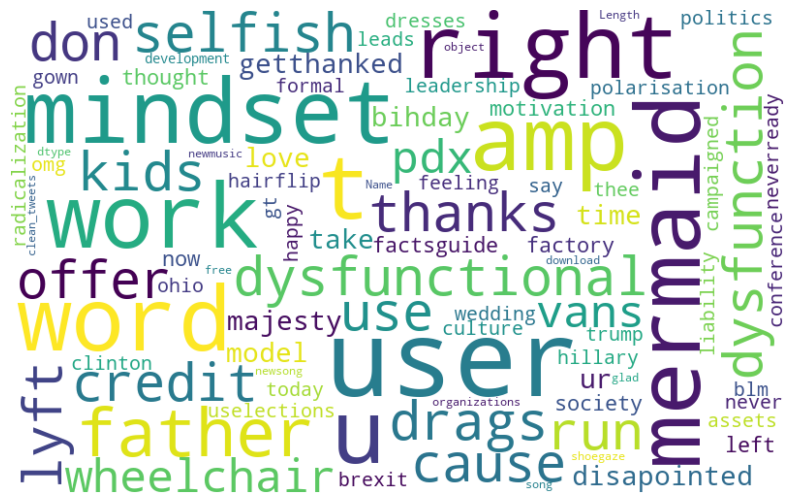

In [20]:
#most populare words in the overall dataset
wordcloud = WordCloud(width=800, height=500, random_state=21, max_words= 100,max_font_size=110,\
                      background_color='white').generate(str(combined_df['clean_tweets'])) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

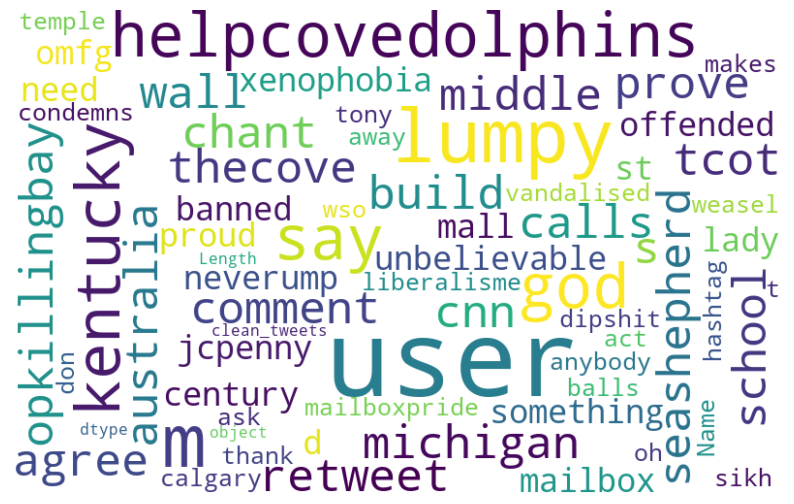

In [21]:
# most popular words in the troll comments labelled dataset

troll = combined_df[combined_df['label'] == 1]['clean_tweets']

wordcloud = WordCloud(width=800, height=500, random_state=21, max_words= 100,max_font_size=110, \
                      background_color='white').generate(str(troll)) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

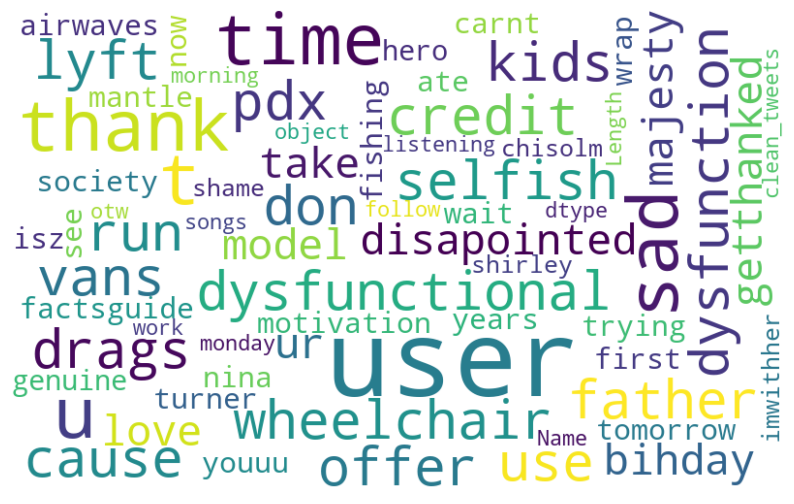

In [22]:
# most popular words in the non-troll comments labelled dataset

no_troll = combined_df[combined_df['label'] == 0]['clean_tweets']

wordcloud = WordCloud(width=800, height=500, random_state=21, max_words= 100,max_font_size=110, \
                      background_color='white').generate(str(no_troll)) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

In [23]:
#most common hashtags overall 

def hashtag_extract(x):    
    hashtags = []  
    # Loop over the words in the tweet  
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)     
    return hashtags

hashtags = hashtag_extract(combined_df['clean_tweets'])
hashtags = [i for i in hashtags if i ] # removing empty lists


In [24]:
len(hashtags)

35860

In [25]:
hashtags = re.sub('[^a-zA-Z#]', ' ', str(hashtags))
hashtags = hashtags.split()

In [26]:
from collections import Counter
hashtags = Counter(hashtags)
most_common_hash = hashtags.most_common(20)

In [27]:
most_common_hash

[('love', 2468),
 ('positive', 1333),
 ('healthy', 905),
 ('smile', 862),
 ('thankful', 756),
 ('fun', 700),
 ('life', 668),
 ('summer', 594),
 ('i', 586),
 ('model', 575),
 ('affirmation', 552),
 ('cute', 545),
 ('fathersday', 545),
 ('me', 520),
 ('blog', 517),
 ('beautiful', 465),
 ('altwaystoheal', 462),
 ('family', 455),
 ('gold', 447),
 ('silver', 445)]

In [28]:
most_common_hash = pd.DataFrame(most_common_hash, columns =['words', 'count'])
most_common_hash

,words,count
0,love,2468
1,positive,1333
2,healthy,905
3,smile,862
4,thankful,756
5,fun,700
6,life,668
7,summer,594
8,i,586
9,model,575


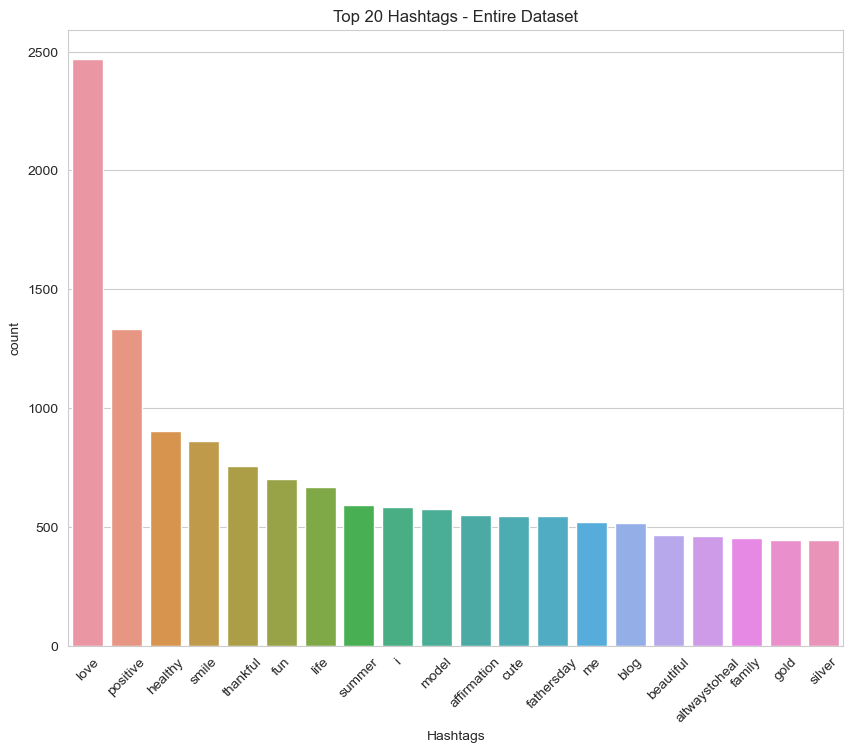

In [29]:
plt.figure(figsize=(10,8))
sns.barplot( x = 'words', y = 'count', data = most_common_hash)
plt.xlabel('Hashtags')
plt.title('Top 20 Hashtags - Entire Dataset')
plt.xticks(rotation =45)
plt.show()

In [30]:
#most common hashtags of troll comments 

def hashtag_extract(x):    
    hashtags = []  
    # Loop over the words in the tweet  
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)     
    return hashtags

hashtags_troll = hashtag_extract(troll)


In [31]:
hashtags_troll = re.sub('[^a-zA-Z#]', ' ', str(hashtags_troll))
hashtags_troll = hashtags_troll.split()
hashtags_troll = Counter(hashtags_troll)
most_common_hash_troll = hashtags_troll.most_common(20)

In [32]:
most_common_hash_troll

[('trump', 136),
 ('politics', 95),
 ('allahsoil', 92),
 ('libtard', 76),
 ('liberal', 75),
 ('sjw', 74),
 ('retweet', 63),
 ('miami', 46),
 ('black', 44),
 ('hate', 33),
 ('tampa', 32),
 ('bigot', 28),
 ('blm', 28),
 ('hispanic', 28),
 ('brexit', 27),
 ('sikh', 27),
 ('calgary', 27),
 ('temple', 26),
 ('wso', 26),
 ('obama', 26)]

In [33]:
most_common_hash_troll = pd.DataFrame(most_common_hash_troll, columns =['words', 'count'])
most_common_hash_troll

,words,count
0,trump,136
1,politics,95
2,allahsoil,92
3,libtard,76
4,liberal,75
5,sjw,74
6,retweet,63
7,miami,46
8,black,44
9,hate,33


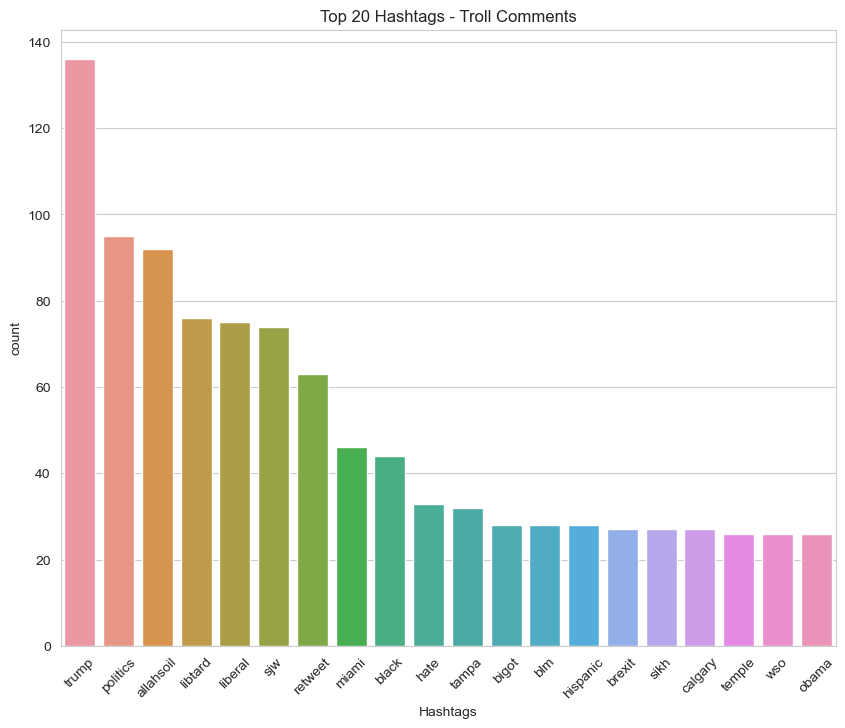

In [34]:
plt.figure(figsize=(10,8))
sns.barplot( x = 'words', y = 'count', data = most_common_hash_troll)
plt.xlabel('Hashtags')
plt.title('Top 20 Hashtags - Troll Comments')
plt.xticks(rotation =45)
plt.show()

### NLP Methods
1. Bag of Words (BOW)
2. Term Frequency - Inverse Document Frequency

In [35]:
#creating the bag of words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=1000)
X_bow = cv.fit_transform(combined_df['clean_tweets']).toarray()
#y = combined_df.iloc[0:31962,1].values


In [36]:
X_bow.shape

(49159, 1000)

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(max_features=1000)
X_tfidf = tf_idf.fit_transform(combined_df['clean_tweets']).toarray()


In [38]:
X_tfidf.shape

(49159, 1000)

In [39]:
count_tokens = cv.vocabulary_
tfidf_tokens = tf_idf.vocabulary_
df_countvect = pd.DataFrame(data = X_bow, columns = count_tokens)
df_tfidfvect = pd.DataFrame(data = X_tfidf,columns = tfidf_tokens)
print("Count Vectorizer\n")
print(df_countvect)
print("\nTD-IDF Vectorizer\n")
print(df_tfidfvect)


Count Vectorizer

       user  when  father  is  and  so  he  his  kids  into  ...  wonder  \
0         0     0       0   0    0   0   0    0     0     0  ...       0   
1         0     0       0   0    0   0   0    0     0     0  ...       0   
2         0     0       0   0    0   0   0    0     0     0  ...       0   
3         0     0       0   0    0   0   0    0     0     0  ...       0   
4         0     0       0   0    0   0   0    0     0     0  ...       0   
...     ...   ...     ...  ..  ...  ..  ..  ...   ...   ...  ...     ...   
49154     0     0       0   0    0   0   0    0     0     0  ...       0   
49155     0     0       0   0    0   0   0    0     0     0  ...       0   
49156     0     0       0   0    0   0   0    0     0     0  ...       0   
49157     0     0       0   0    0   0   0    0     0     0  ...       0   
49158     0     0       0   0    0   0   0    0     0     0  ...       0   

       flag  dress  flower  called  died  workout  fit  three  trendi

### Modeling
Using the classfication algorithms - Logistic Regression, Naive Bayes, Random Forest and XGBoost.
I have used the evaluation metric as Precision since the dataset has highly imbalanced classes and the cost of False Positives (classifiying/ predicting a tweet as a troll when it is not a troll) is also high. 

In [40]:
combined_df


,id,label,tweet,clean_tweets
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,user user thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation
...,...,...,...,...
49154,49155,NaN,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3,thought factory left right polarisation #trump #uselections #leadership #politics #brexit #blm gt
49155,49156,NaN,feeling like a mermaid ð #hairflip #neverready #formal #wedding #gown #dresses #mermaid â¦,feeling like a mermaid #hairflip #neverready #formal #wedding #gown #dresses #mermaid
49156,49157,NaN,"#hillary #campaigned today in #ohio((omg)) &amp; used words like ""assets&amp;liability"" never once did #clinton say thee(word) #radicalization",#hillary #campaigned today in #ohio omg amp used words like assets amp liability never once did #clinton say thee word #radicalization
49157,49158,NaN,"happy, at work conference: right mindset leads to culture-of-development organizations #work #mindset",happy at work conference right mindset leads to culture of development organizations #work #mindset


In [41]:
# Splitting the combined_df into training and test test as before since the entire dataset is complete
train_bow = X_bow[0:31962]
test_bow = X_bow[31963:]
y = combined_df.iloc[0:31962,1].values

In [42]:
# building the training and validation set 
from sklearn.model_selection import train_test_split
X_train_bow, X_val_bow, y_train_bow, y_val_bow = train_test_split(train_bow, y, test_size=0.33, random_state=42)

In [43]:
# Logistic Regression 
# Bag of Words 
from sklearn.linear_model import LogisticRegression
classifier_bow_lr = LogisticRegression(max_iter = 1000)
classifier_bow_lr.fit(X_train_bow,y_train_bow)


LogisticRegression(max_iter=1000)

In [44]:
#Calculating the predictions on the validation set and evaluating the model 
y_pred_bow = classifier_bow_lr.predict(X_val_bow)

y_pred_bow

array([0., 0., 0., ..., 0., 0., 0.])

In [45]:
from sklearn.metrics import confusion_matrix, precision_score, f1_score

cm_bow_lr = confusion_matrix(y_val_bow, y_pred_bow)
precision_score_lr_bow = precision_score(y_val_bow, y_pred_bow)


In [46]:
cm_bow_lr

array([[9705,  101],
       [ 460,  282]])

In [47]:
precision_score_lr_bow

0.7362924281984334

In [48]:
# Logistic Regression 
# TF_IDF 

# Splitting the combined_df into training and test test as before since the entire dataset is complete
train_tfidf = X_tfidf[0:31962]
test_tfidf = X_tfidf[31963:]
y = combined_df.iloc[0:31962,1].values

In [49]:
# building the training and validation set 
from sklearn.model_selection import train_test_split
X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(train_tfidf, y, test_size=0.33, random_state=42)

In [50]:
classifier_tfidf_lr = LogisticRegression()
classifier_tfidf_lr.fit(X_train_tfidf,y_train_tfidf)

LogisticRegression()

In [51]:
#Calculating the predictions on the validation set and evaluating the model 
y_pred_tfidf = classifier_tfidf_lr.predict(X_val_tfidf)

y_pred_tfidf

array([0., 0., 0., ..., 0., 0., 0.])

In [52]:

cm_tfidf_lr = confusion_matrix(y_val_tfidf, y_pred_tfidf)

precision_score_lr_tfidf = precision_score(y_val_tfidf, y_pred_tfidf)


In [53]:
cm_tfidf_lr

array([[9750,   56],
       [ 526,  216]])

In [54]:
precision_score_lr_tfidf

0.7941176470588235

In [55]:
#NaiveBayes
#Bag of Words

from sklearn.naive_bayes import GaussianNB
classifier_bow_nb = GaussianNB()
classifier_bow_nb.fit(X_train_bow,y_train_bow)

GaussianNB()

In [56]:
#Calculating the predictions on the validation set and evaluating the model 
y_pred_bow = classifier_bow_nb.predict(X_val_bow)

y_pred_bow

array([0., 0., 0., ..., 1., 1., 0.])

In [57]:
cm_bow_nb = confusion_matrix(y_val_bow, y_pred_bow)

precision_score_nb_bow = precision_score(y_val_bow, y_pred_bow)

In [58]:
cm_bow_nb

array([[5109, 4697],
       [  57,  685]])

In [59]:
precision_score_nb_bow

0.1272761055369751

In [60]:
#NaiveBayes
# TD-IDF
classifier_tfidf_nb = GaussianNB()
classifier_tfidf_nb.fit(X_train_tfidf,y_train_tfidf)


GaussianNB()

In [61]:
y_pred_tfidf = classifier_tfidf_nb.predict(X_val_tfidf)

y_pred_tfidf

array([0., 0., 0., ..., 1., 1., 0.])

In [62]:
cm_tfidf_nb = confusion_matrix(y_val_tfidf, y_pred_tfidf)

precision_score_nb_tfidf = precision_score(y_val_tfidf, y_pred_tfidf)

In [63]:
cm_tfidf_nb

array([[5348, 4458],
       [  65,  677]])

In [64]:
precision_score_nb_tfidf

0.13184031158714704

In [65]:
#Random Forest
#Bag of Words
from sklearn.ensemble import RandomForestClassifier
classifier_bow_rf = RandomForestClassifier()
classifier_bow_rf.fit(X_train_bow,y_train_bow)

RandomForestClassifier()

In [66]:
#Calculating the predictions on the validation set and evaluating the model 
y_pred_bow = classifier_bow_rf.predict(X_val_bow)

y_pred_bow

array([0., 0., 0., ..., 0., 0., 0.])

In [67]:
cm_bow_rf = confusion_matrix(y_val_bow, y_pred_bow)

precision_score_rf_bow = precision_score(y_val_bow, y_pred_bow)

In [68]:
cm_bow_rf

array([[9734,   72],
       [ 470,  272]])

In [69]:
precision_score_rf_bow

0.7906976744186046

In [70]:
#Random Forest
#TF-IDF

In [71]:
classifier_tfidf_rf = RandomForestClassifier()
classifier_tfidf_rf.fit(X_train_tfidf,y_train_tfidf)

RandomForestClassifier()

In [72]:
y_pred_tfidf = classifier_tfidf_rf.predict(X_val_tfidf)

y_pred_tfidf

array([0., 0., 0., ..., 0., 0., 0.])

In [73]:
cm_tfidf_rf = confusion_matrix(y_val_tfidf, y_pred_tfidf)

precision_score_rf_tfidf = precision_score(y_val_tfidf, y_pred_tfidf)

In [74]:
cm_tfidf_rf

array([[9757,   49],
       [ 475,  267]])

In [75]:
precision_score_rf_tfidf

0.8449367088607594

In [76]:
#XGBoost
#Bag of Words

In [77]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [78]:
from xgboost import XGBClassifier

In [79]:
classifier_bow_xgb = XGBClassifier()
classifier_bow_xgb.fit(X_train_bow,y_train_bow)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [80]:
#Calculating the predictions on the validation set and evaluating the model 
y_pred_bow = classifier_bow_xgb.predict(X_val_bow)

y_pred_bow

array([0, 0, 0, ..., 0, 0, 0])

In [81]:
cm_bow_xgb = confusion_matrix(y_val_bow, y_pred_bow)

precision_score_xgb_bow = precision_score(y_val_bow, y_pred_bow)

In [82]:
cm_bow_xgb

array([[9742,   64],
       [ 476,  266]])

In [83]:
precision_score_xgb_bow

0.806060606060606

In [84]:
#XGBoost
#TFIDF

In [85]:
classifier_tfidf_xgb = XGBClassifier()
classifier_tfidf_xgb.fit(X_train_tfidf,y_train_tfidf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [86]:
y_pred_tfidf = classifier_tfidf_xgb.predict(X_val_tfidf)

y_pred_tfidf

array([0, 0, 0, ..., 0, 0, 0])

In [87]:
cm_tfidf_xgb = confusion_matrix(y_val_tfidf, y_pred_tfidf)

precision_score_xgb_tfidf = precision_score(y_val_tfidf, y_pred_tfidf)

In [88]:
cm_tfidf_xgb

array([[9746,   60],
       [ 484,  258]])

In [89]:
precision_score_xgb_tfidf

0.8113207547169812

In [90]:
#Summary of Results 

In [91]:
bow = [precision_score_lr_bow,precision_score_nb_bow,precision_score_rf_bow,precision_score_xgb_bow]
tfidf = [precision_score_lr_tfidf,precision_score_nb_tfidf, precision_score_rf_tfidf, precision_score_xgb_tfidf]

In [92]:
a = pd.DataFrame(data = bow, index = ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'XGBoost'],columns = ['BOW'])
b = pd.DataFrame(data = tfidf, index = ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'XGBoost'],columns = ['TF-IDF'])


In [93]:
summary = pd.concat([a,b], axis= 1,ignore_index=False)

In [94]:
summary

,BOW,TF-IDF
Logistic Regression,0.736292,0.794118
Naive Bayes,0.127276,0.131840
Random Forest,0.790698,0.844937
XGBoost,0.806061,0.811321


Two observations:
1. We observe that the TF-IDF performs better than Bag of Words across all models, as expected.
2. We see that Random Forest performs better for TF-IDF and XGBoost performs better for Bag of Words when we use precision as our evaluation metric.

So using the Random Forest Model to make predictions on our test set for Bag of Words and using XGBoost to make predictions on our test set for TF-IDF 

In [95]:
bow_test = classifier_bow_rf.predict(test_bow)
tfidf_test = classifier_tfidf_xgb.predict(test_tfidf)

bow_test


array([0., 0., 0., ..., 0., 0., 0.])

In [96]:
tfidf_test

array([1, 0, 0, ..., 0, 0, 0])